In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [77]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


### utilities

In [132]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def build_topic_word_distr(topics, word_topic_cos, words, topic_word_window_width, word_doc_frequency):
    topic_word_distr = pd.DataFrame(data=0.0, columns=topics, index=words)

    for topic in tqdm(range(len(topics))):
        word_topic_co = word_topic_cos[topic]
        word_word_co = pd.DataFrame(data=0.0, columns=word_topic_co[:topic_word_window_width].index, index=words)

        for index, (top_word, corelation) in enumerate(word_topic_co.items()):
            if index == topic_word_window_width:
                break

            word_word_frequency = corelation * word_doc_binary_freqency[word_doc_binary_freqency[top_word] > 0].sum(0)
            trust_factor = sigmoid(word_doc_frequency)

            word_word_co[top_word] = (word_word_frequency * trust_factor) / word_doc_frequency
        topic_word_distr[topics[topic]] = word_word_co.max(1)
    return topic_word_distr

def infer_topic(label_classes, doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()
    doc_word_freq_norm = (doc_vector > 0).astype(int)
#     doc_word_freq_norm = doc_vector / doc_vector.sum() if doc_vector.sum() else 0

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [133]:
# total number of samples needed
datasize = 1000
randomize = False

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [134]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape, dtype=int)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [135]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 1000 docs and 7 classes: ['soc', 'rec', 'talk', 'alt', 'comp', 'misc', 'sci']


### clean dataset

In [136]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

clean_docs = [clean_doc(doc) for doc in docs]
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [137]:
# initialize the count vectorizer
# count_vectorizer = CountVectorizer()
count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 15674


### Prepare Datatset

In [138]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
# train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
# train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=0)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
# test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)
# test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=0)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

670 train_docs, 330 test docs


In [139]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = train_labels
document_word_binary_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (670, 15675)


In [140]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [141]:
document_word_frequency.head()

,00,000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,00000011b,...,zombies,zombo,zone,zoom,zoomed,zubov,zum,zupancic,zzz,__labels__
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [142]:
document_word_binary_frequency.head()

,00,000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,00000011b,...,zombies,zombo,zone,zoom,zoomed,zubov,zum,zupancic,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Prepare Binary Dataset

In [143]:
#reduce freq in doc to bin value of 1 or 0
# word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')
word_doc_binary_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

### Topic and word corelation

In [144]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_frequency).fillna(0)
    
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (15674, 7)


In [145]:
topic_word_distr.head()

,soc,rec,talk,alt,comp,misc,sci
00,0.113835,0.010511,0.326446,0.0,0.037204,0.175770,0.096223
000,0.000000,0.304751,0.106161,0.0,0.015801,0.120355,0.164098
00000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500947
00000000b,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500947
00000001,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500947


In [146]:
label_classes

['soc', 'rec', 'talk', 'alt', 'comp', 'misc', 'sci']

In [147]:
label_class = 'comp'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

windows    0.909878
scsi       0.882947
ax         0.875485
hi         0.854997
file       0.846335
             ...   
bi         0.000458
68         0.000412
rk         0.000405
gi         0.000165
pm         0.000158
Name: comp, Length: 4148, dtype: float64

In [148]:
word="the"
topic_word_distr.loc[word].sort_values(ascending=False)

sci     0.228157
talk    0.220227
comp    0.218930
rec     0.207014
soc     0.061367
alt     0.038383
misc    0.025922
Name: the, dtype: float64

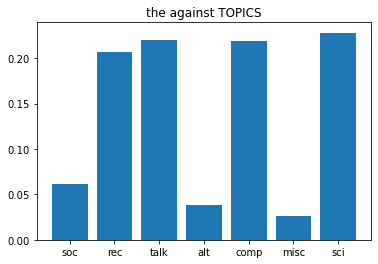

In [149]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [151]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> train-accuracy is 80.75%



### Evaluating Topic Model with test set

In [152]:
score = 0
print("Evaluating Topic Model...")

misclasified = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclasified.append(doc_index)
    

accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 61.52%



### Topic and word corelation

In [153]:
word_topic_cos = []
for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    word_topic_co = (word_topic_frequency * trust_factor) / word_doc_frequency
    word_topic_co = word_topic_co[word_topic_co > 0.5].sort_values(ascending=False)
    
    word_topic_cos.append(word_topic_co)
    print(f"topic {topic} has {word_topic_co.shape} skew words")

topic 0 has (677,) skew words
topic 1 has (2393,) skew words
topic 2 has (3403,) skew words
topic 3 has (223,) skew words
topic 4 has (2083,) skew words
topic 5 has (374,) skew words
topic 6 has (2474,) skew words


In [154]:
topic_index = label_classes.index('sci')
word_topic_cos[topic_index][word_topic_cos[topic_index] > 0].sort_values(ascending=False)

encryption    0.890561
key           0.838395
moon          0.776171
keys          0.756411
nasa          0.756235
                ...   
collisions    0.500474
ncryption     0.500474
molecules     0.500474
neutral       0.500406
swollen       0.500021
Length: 2474, dtype: float64

### Building topic model

In [155]:
converged = False
last_accuracy = last_max_accuracy = 0
window_size = 100
window_step = window_base_step = 100
decay_factor = 10

while not converged:
    print("Building Topic_word_distr_prime...")
    topic_word_distr_prime = build_topic_word_distr(label_classes, word_topic_cos, word_doc_binary_freqency.columns, window_size, word_doc_frequency)

    score = 0
    print("Evaluating Topic Model...")
    for doc_index in tqdm(range(len(train_labels))):
        doc_vector = train_doc_vectors[doc_index]
        doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr_prime)
        score += int(doc_topic == label_classes[train_labels[doc_index]])

    accuracy = score / (doc_index + 1)
    print(f"==> topic_word_distr_prime has shape {topic_word_distr_prime.shape} from window_size {window_size} and window_step {window_step} accuracy is {accuracy*100:.2f}%\n")
    
    if abs(accuracy - last_max_accuracy) < .001:
        print("accuracy low", abs(accuracy - last_max_accuracy))
        converged = True
        
    elif accuracy >= last_max_accuracy:
        window_size += window_step
        last_max_accuracy = accuracy
    
    else:
        if last_accuracy == last_max_accuracy:
            window_size -= window_step
            window_step = int(window_step / decay_factor)
            
            if not window_step:
                print("window decayed!!")
                converged = False
        window_size += window_step
        
    last_accuracy = accuracy

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (15674, 7) from window_size 100 and window_step 100 accuracy is 72.09%

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (15674, 7) from window_size 200 and window_step 100 accuracy is 74.63%

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (15674, 7) from window_size 300 and window_step 100 accuracy is 74.03%

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (15674, 7) from window_size 210 and window_step 10 accuracy is 74.78%

Building Topic_word_distr_prime...



Evaluating Topic Model...



==> topic_word_distr_prime has shape (15674, 7) from window_size 220 and window_step 10 accuracy is 74.78%

accuracy low 0.0


### Testing Topic Model

In [156]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr_prime)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy = score / (doc_index + 1)
print(f"==> topic_word_distr has shape {topic_word_distr_prime.shape} from window_size {window_size} and window_step {window_step} test-accuracy is {accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> topic_word_distr has shape (15674, 7) from window_size 220 and window_step 10 test-accuracy is 55.45%



### Using Multinomial Naive Bayes

In [157]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

clf.score(train_doc_vectors, train_labels), clf.score(test_doc_vectors, test_labels)

(0.9716417910447761, 0.7333333333333333)

### Using Logistic Regression to Learn Topic Model

In [158]:
logistic_regression_model = LogisticRegression(
    random_state=0, 
    fit_intercept=False,
#     multi_class="multinomial", 
#     solver="lbfgs"
)

In [159]:
logistic_regression_model.fit(train_doc_vectors, train_labels)

print(f"{len(train_labels)} training sample(s), {len(test_labels)} test sample(s)")

670 training sample(s), 330 test sample(s)


In [160]:
train_accuracy = logistic_regression_model.score(train_doc_vectors, train_labels)
test_accuracy = logistic_regression_model.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%")

training_accuarcy = 90.90%, test_accuarcy = 66.36%


In [161]:
label_class = 'comp'
np.array(vocabulary)[logistic_regression_model.coef_[label_classes.index(label_class)].argsort()][::-1]

array(['windows', 'drive', 'anyone', ..., 'people', 'he', 'of'],
      dtype='<U79')

In [162]:
word="keyboard"
relation = pd.DataFrame(data=logistic_regression_model.coef_[:, vocabulary.index(word)].reshape((1,7)), columns=label_classes).T[0]
relation.sort_values(ascending=False)

comp    0.502364
misc   -0.038691
alt    -0.043128
soc    -0.049741
talk   -0.102848
rec    -0.125203
sci    -0.142755
Name: 0, dtype: float64

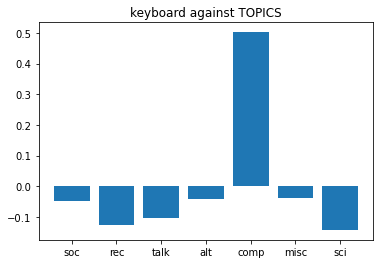

In [163]:
plt.title(f"{word} against TOPICS")
plt.bar(relation.index, relation)
plt.show()